In [1]:
workDir = '/home/chantal/Chazy/Chazy_SIP/data/'
figDir = '/home/chantal/Chazy/Chazy_SIP/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqFile = 'SIP_unk'


# l2fc params
l2fc_threshold = 0.25
BD_windows = ['1.70-1.73', '1.72-1.75', '1.74-1.77']
padj_cutoff = 0.1

# misc
nprocs = 20

In [2]:
import os
%load_ext rpy2.ipython
#%load_ext pushnote

In [3]:
%%R
library(DESeq2)
library(phyloseq)
library(grid); library(gridExtra)
library(plyr); library(dplyr)
library(tidyr)
library(ggplot2)
library(doParallel)
library(foreach)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: S4Vectors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: stats4

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: BiocGenerics

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘BiocGenerics’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/funct

In [4]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
if not os.path.isdir(figDir):
    os.makedirs(figDir)    

In [5]:
%%R -i l2fc_threshold -i BD_windows -i nprocs -i padj_cutoff

cat('Params loaded in R\n')

Params loaded in R


In [69]:
%%R
df.l2fc = read.table('data/l2fc_sparse-maxRejH.txt', sep='\t', header = TRUE)
df.l2fc = df.l2fc %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

In [70]:
%%R
df.13Cell.NTH = filter(df.l2fc, Treatment == '13C', Land_Management == 'NTH') %>% 
            select(Day, Land_Management, OTU, log2FoldChange, padj, Rank2) %>%
            plyr::rename(c("log2FoldChange" = "LFC_NTH", 'padj' = 'p_NTH'))

df.13Cell.PTH = filter(df.l2fc, Treatment == '13C', Land_Management == 'PTH') %>% 
            select(Day, Land_Management, OTU, log2FoldChange, padj, Rank2) %>%
            plyr::rename(c("log2FoldChange" = "LFC_PTH", 'padj' = 'p_PTH'))

print(head(df.13Cell.NTH))
print(head(df.13Cell.PTH))

  Day Land_Management      OTU    LFC_NTH p_NTH          Rank2
1   3             NTH OTU.4163  0.2905525     1    Chloroflexi
2   3             NTH OTU.5493 -0.2477539     1    Chloroflexi
3   3             NTH OTU.1739 -0.3623365     1 Planctomycetes
4   3             NTH OTU.1813  0.0000000     1 Planctomycetes
5   3             NTH  OTU.778  0.4419146     1 Planctomycetes
6   3             NTH OTU.5511  0.6736674     1 Planctomycetes
  Day Land_Management       OTU    LFC_PTH p_PTH          Rank2
1  30             PTH  OTU.6957 -1.4500766     1 Planctomycetes
2  30             PTH OTU.11282  0.2995194     1 Planctomycetes
3  30             PTH  OTU.6540  0.1350116     1 Planctomycetes
4  30             PTH OTU.21177 -2.1680128     1 Planctomycetes
5  30             PTH OTU.15890 -1.4432889     1 Planctomycetes
6  30             PTH OTU.28312 -0.5628124     1 Planctomycetes


In [114]:
%%R
df.13Cell = left_join(df.13Cell.NTH, df.13Cell.PTH, by = c('OTU', 'Day', 'Rank2'))

In [117]:
%%R
df.13Cell.noresp = df.13Cell %>% na.omit() %>% group_by(Rank2) %>% summarise(n = sum(p_NTH <=0.10 & p_PTH <=0.10)) %>%
                    filter(n == 0)
df.13Cell.noresp %>% as.data.frame()

                     Rank2 n
1                BHI80-139 0
2  Candidate_division_BRC1 0
3   Candidate_division_OD1 0
4  Candidate_division_OP11 0
5   Candidate_division_OP3 0
6   Candidate_division_SR1 0
7   Candidate_division_TM7 0
8   Candidate_division_WS3 0
9               Chlamydiae 0
10                Chlorobi 0
11           Elusimicrobia 0
12              Firmicutes 0
13        Gemmatimonadetes 0
14                  GOUTA4 0
15             JL-ETNP-Z39 0
16                NPL-UPA2 0
17                  SM2F11 0
18             Tenericutes 0
19             Thermotogae 0
20                     TM6 0


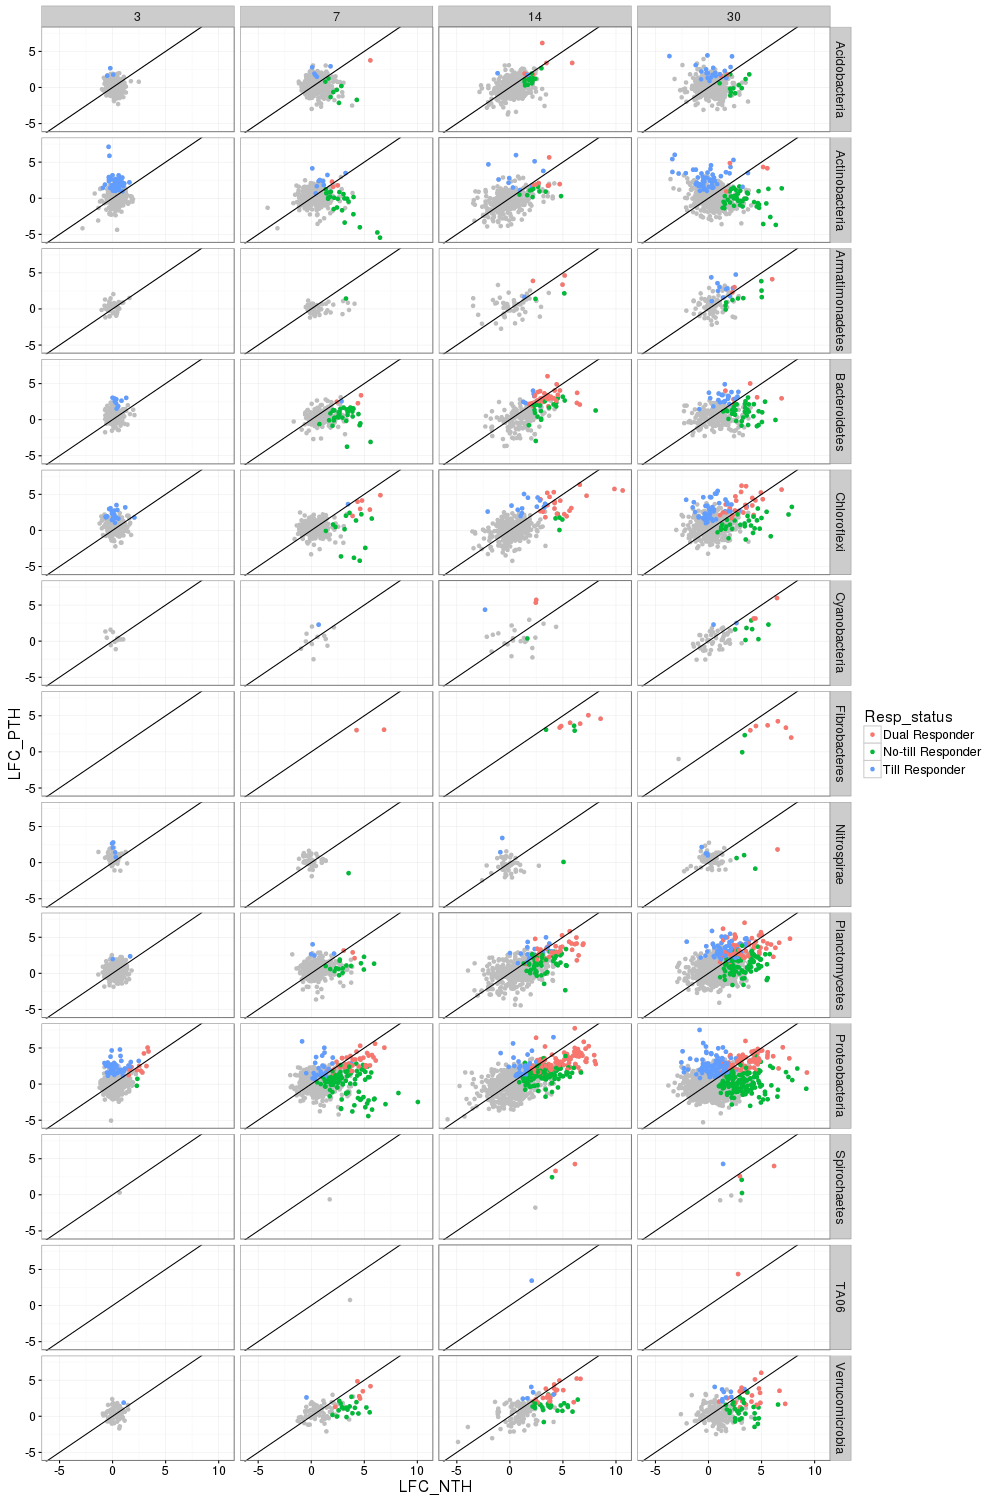

In [315]:
%%R -w 1000 -h 1500

df.13Cell.filt = df.13Cell %>% na.omit %>% filter(!(Rank2 %in% df.13Cell.noresp$Rank2))

df.13Cell.sig = filter(df.13Cell.filt, p_NTH <=0.10 | p_PTH <=0.10)

df.13Cell.sig$Resp_status[df.13Cell.sig$p_PTH <= 0.10 & df.13Cell.sig$p_NTH > 0.10 ] = "Till Responder"
df.13Cell.sig$Resp_status[df.13Cell.sig$p_NTH <= 0.10 & df.13Cell.sig$p_PTH > 0.10 ] = "No-till Responder"
df.13Cell.sig$Resp_status[df.13Cell.sig$p_NTH <= 0.10 & df.13Cell.sig$p_PTH <= 0.10 ] = "Dual Responder"

p = ggplot() + geom_point(data = df.13Cell.filt, aes(x = LFC_NTH, y = LFC_PTH), color = 'grey') + 
            geom_point(data = df.13Cell.sig, aes(x = LFC_NTH, y = LFC_PTH, color = Resp_status))  + 
            facet_grid(Rank2~Day,) + geom_abline(intercept = 0, slope = 1)

p = p + theme_bw() +
    theme(
        text = element_text(size=16))
p

In [120]:
%%R
df.13Xyl.NTH = filter(df.l2fc, Treatment == '13X', Land_Management == 'NTH') %>% 
            select(Day, Land_Management, OTU, log2FoldChange, padj, Rank2) %>%
            plyr::rename(c("log2FoldChange" = "LFC_NTH", 'padj' = 'p_NTH'))

df.13Xyl.PTH = filter(df.l2fc, Treatment == '13X', Land_Management == 'PTH') %>% 
            select(Day, Land_Management, OTU, log2FoldChange, padj, Rank2) %>%
            plyr::rename(c("log2FoldChange" = "LFC_PTH", 'padj' = 'p_PTH'))

print(head(df.13Xyl.NTH))
print(head(df.13Xyl.PTH))

  Day Land_Management       OTU    LFC_NTH p_NTH          Rank2
1   1             NTH  OTU.4940 -0.8882108     1  Acidobacteria
2   1             NTH  OTU.1739  0.7078118     1 Planctomycetes
3   1             NTH  OTU.2343  0.4460971     1 Planctomycetes
4   1             NTH  OTU.2283 -0.2910877     1 Planctomycetes
5   1             NTH  OTU.1809 -0.9613290     1 Planctomycetes
6   1             NTH OTU.18028 -0.3373200     1 Planctomycetes
  Day Land_Management       OTU     LFC_PTH p_PTH          Rank2
1   3             PTH  OTU.1813  0.18725056     1 Planctomycetes
2   3             PTH  OTU.2180 -0.08299578     1 Planctomycetes
3   3             PTH  OTU.2343 -0.51535570     1 Planctomycetes
4   3             PTH  OTU.3171 -1.46777179     1 Planctomycetes
5   3             PTH  OTU.2298 -0.77464041     1 Planctomycetes
6   3             PTH OTU.20936 -0.44750514     1 Planctomycetes


In [178]:
%%R
df.13Xyl = left_join(df.13Xyl.NTH, df.13Xyl.PTH, by = c('OTU', 'Day', 'Rank2'))

In [179]:
%%R
df.13Xyl.noresp = df.13Xyl %>% na.omit() %>% group_by(Rank2) %>% summarise(n = sum(p_NTH <=0.10 & p_PTH <=0.10)) %>%
                    filter(n == 0)
df.13Xyl.noresp %>% as.data.frame()

                     Rank2 n
1            Acidobacteria 0
2          Armatimonadetes 0
3                BHI80-139 0
4   Candidate_division_OD1 0
5  Candidate_division_OP11 0
6   Candidate_division_OP3 0
7               Chlamydiae 0
8                 Chlorobi 0
9            Elusimicrobia 0
10           Fibrobacteres 0
11        Gemmatimonadetes 0
12                  GOUTA4 0
13             JL-ETNP-Z39 0
14             Nitrospirae 0
15                NPL-UPA2 0
16                  SM2F11 0
17            Spirochaetes 0
18             Thermotogae 0
19                     TM6 0


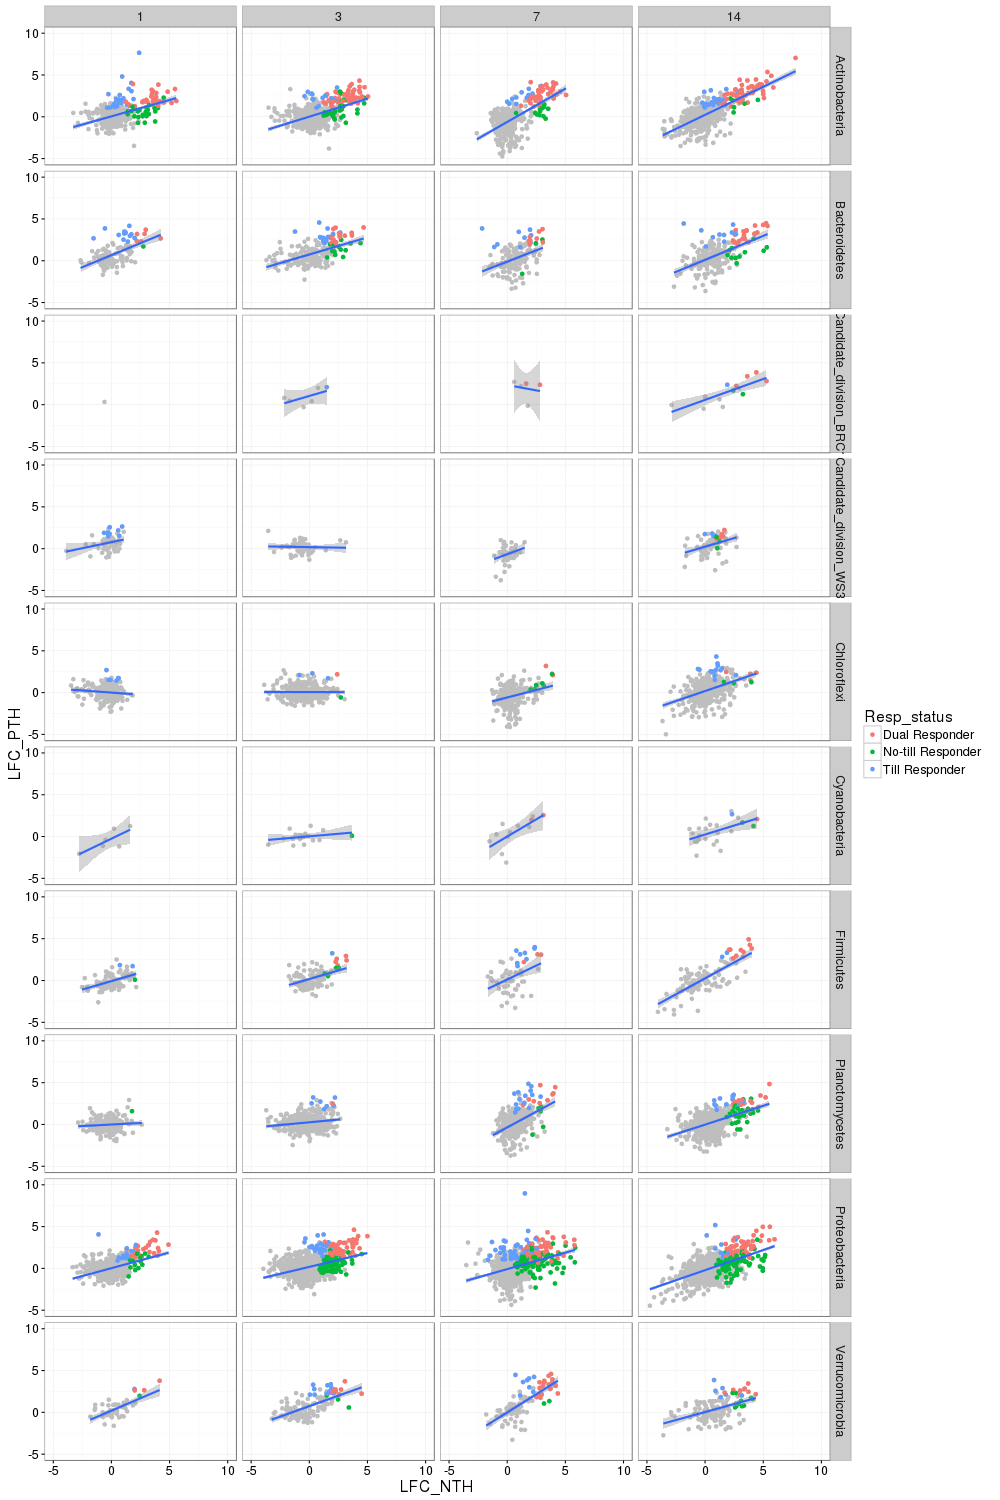

In [180]:
%%R -w 1000 -h 1500

df.13Xyl.filt = df.13Xyl %>% na.omit %>% filter(!(Rank2 %in% df.13Xyl.noresp$Rank2))

df.13Xyl.sig = filter(df.13Xyl.filt, p_NTH <=0.10 | p_PTH <=0.10)

df.13Xyl.sig$Resp_status[df.13Xyl.sig$p_PTH <= 0.10 & df.13Xyl.sig$p_NTH > 0.10 ] = "Till Responder"
df.13Xyl.sig$Resp_status[df.13Xyl.sig$p_NTH <= 0.10 & df.13Xyl.sig$p_PTH > 0.10 ] = "No-till Responder"
df.13Xyl.sig$Resp_status[df.13Xyl.sig$p_NTH <= 0.10 & df.13Xyl.sig$p_PTH <= 0.10 ] = "Dual Responder"

p = ggplot() + geom_point(data = df.13Xyl.filt, aes(x = LFC_NTH, y = LFC_PTH), color = 'grey') + 
            geom_point(data = df.13Xyl.sig, aes(x = LFC_NTH, y = LFC_PTH, color = Resp_status))  + 
            geom_smooth(data = df.13Xyl.filt, aes(x = LFC_NTH, y = LFC_PTH), method="lm", se=TRUE) +
            ylim(-5,10) + xlim(-5, 10) +
            facet_grid(Rank2~Day) #+ geom_abline(intercept = 0, slope = 1, color = 'grey')

p = p + theme_bw() +
    theme(
        text = element_text(size=16))
p

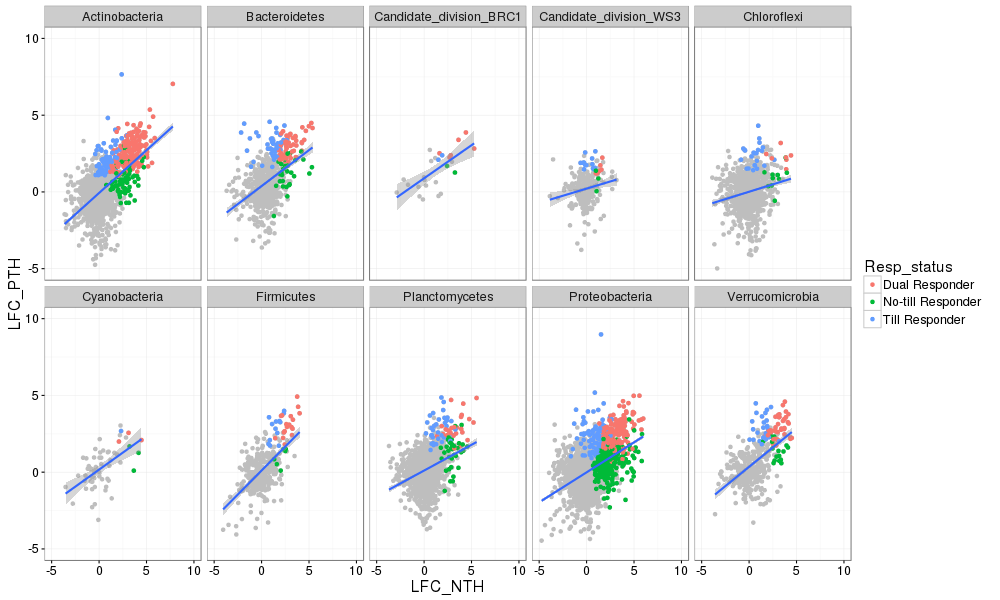

In [181]:
%%R -w 1000 -h 600

p = ggplot() + geom_point(data = df.13Xyl.filt, aes(x = LFC_NTH, y = LFC_PTH), color = 'grey') + 
            geom_point(data = df.13Xyl.sig, aes(x = LFC_NTH, y = LFC_PTH, color = Resp_status))  + 
            geom_smooth(data = df.13Xyl.filt, aes(x = LFC_NTH, y = LFC_PTH), method="lm", se=TRUE) +
            ylim(-5,10) + xlim(-5, 10) +
            facet_wrap(~Rank2, ncol = 5) #+ geom_abline(intercept = 0, slope = 1, color = 'grey')

p = p + theme_bw() +
    theme(
        text = element_text(size=16))
p

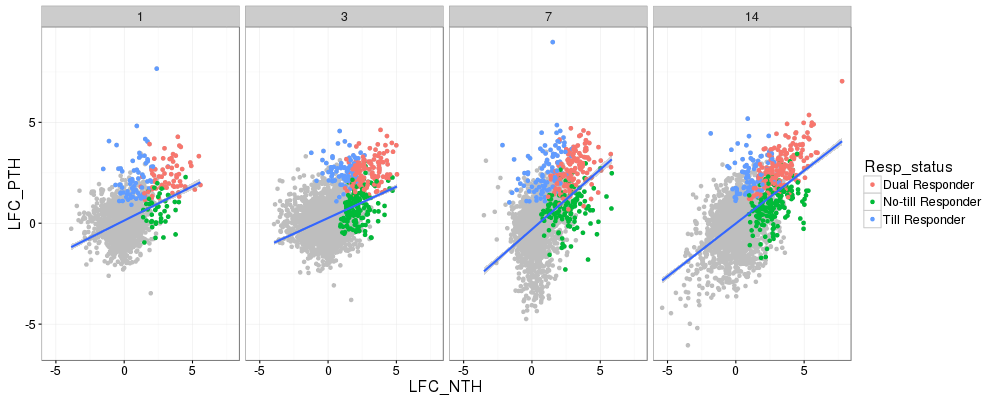

In [182]:
%%R -w 1000 -h 400

df.13Xyl.filt = df.13Xyl %>% na.omit %>% filter(!(Rank2 %in% df.13Xyl.noresp$Rank2))

df.13Xyl.sig = filter(df.13Xyl.filt, p_NTH <=0.10 | p_PTH <=0.10)

df.13Xyl.sig$Resp_status[df.13Xyl.sig$p_PTH <= 0.10 & df.13Xyl.sig$p_NTH > 0.10 ] = "Till Responder"
df.13Xyl.sig$Resp_status[df.13Xyl.sig$p_NTH <= 0.10 & df.13Xyl.sig$p_PTH > 0.10 ] = "No-till Responder"
df.13Xyl.sig$Resp_status[df.13Xyl.sig$p_NTH <= 0.10 & df.13Xyl.sig$p_PTH <= 0.10 ] = "Dual Responder"

p = ggplot() + geom_point(data = df.13Xyl.filt, aes(x = LFC_NTH, y = LFC_PTH), color = 'grey') + 
            geom_point(data = df.13Xyl.sig, aes(x = LFC_NTH, y = LFC_PTH, color = Resp_status))  + 
            geom_smooth(data = df.13Xyl.filt, aes(x = LFC_NTH, y = LFC_PTH), method="lm", se=TRUE) +
            facet_grid(~Day) 

p = p + theme_bw() +
    theme(
        text = element_text(size=16))
p

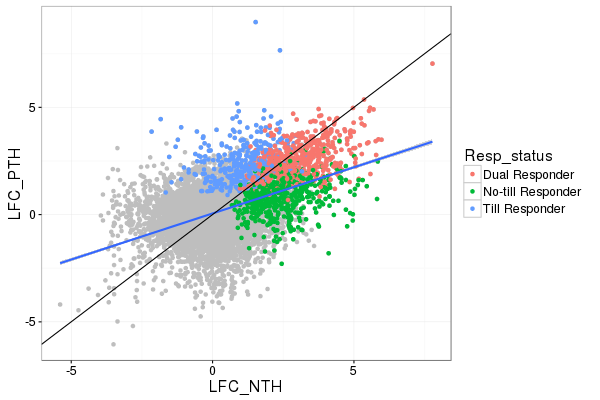

In [183]:
%%R -w 600 -h 400

df.13Xyl.filt = df.13Xyl %>% na.omit %>% filter(!(Rank2 %in% df.13Xyl.noresp$Rank2))

df.13Xyl.sig = filter(df.13Xyl.filt, p_NTH <=0.10 | p_PTH <=0.10)

df.13Xyl.sig$Resp_status[df.13Xyl.sig$p_PTH <= 0.10 & df.13Xyl.sig$p_NTH > 0.10 ] = "Till Responder"
df.13Xyl.sig$Resp_status[df.13Xyl.sig$p_NTH <= 0.10 & df.13Xyl.sig$p_PTH > 0.10 ] = "No-till Responder"
df.13Xyl.sig$Resp_status[df.13Xyl.sig$p_NTH <= 0.10 & df.13Xyl.sig$p_PTH <= 0.10 ] = "Dual Responder"

p = ggplot() + geom_point(data = df.13Xyl.filt, aes(x = LFC_NTH, y = LFC_PTH), color = 'grey') + 
            geom_point(data = df.13Xyl.sig, aes(x = LFC_NTH, y = LFC_PTH, color = Resp_status))  +
            geom_smooth(data = df.13Xyl.filt, aes(x = LFC_NTH, y = LFC_PTH), method="lm", se=TRUE) +
            geom_abline(intercept = 0, slope = 1)

p = p + theme_bw() +
    theme(
        text = element_text(size=16))
p

### Testing linear regression : is slope of 1 within 95% confidence interval?

In [304]:
%%R
linreg = function(phylum, df, D) {
    df.phyl = df %>% filter(Rank2 %in% phylum & Day == D)
    x = df.phyl$LFC_NTH
    y = df.phyl$LFC_PTH
    
    ifelse(x  0, return(NA), x)
    
    reg = lm(y~x)
    reg2 = lm(y ~1 + offset(x))
    test = anova(reg, reg2) 
    return(test$`Pr(>F)`)
    
}

In [313]:
%%R
test = filter(df.13Cell.filt, Rank2 == 'Fibrobacteres', Day == 7)
x = test$LFC_NTH

str(x)

 num [1:2] 4.27 6.86


### Looking at all combo LFC values

In [292]:
%%R
phyl.xyl = unique(df.13Xyl.filt$Rank2)

phyl.cell = unique(df.13Cell.filt$Rank2)

In [293]:
%%R
print(phyl.xyl)
print(phyl.cell)

 [1] "Planctomycetes"          "Candidate_division_WS3" 
 [3] "Actinobacteria"          "Chloroflexi"            
 [5] "Cyanobacteria"           "Firmicutes"             
 [7] "Bacteroidetes"           "Verrucomicrobia"        
 [9] "Proteobacteria"          "Candidate_division_BRC1"
 [1] "Planctomycetes"  "Nitrospirae"     "Proteobacteria"  "Armatimonadetes"
 [5] "Actinobacteria"  "Chloroflexi"     "Acidobacteria"   "Cyanobacteria"  
 [9] "Bacteroidetes"   "Verrucomicrobia" "TA06"            "Spirochaetes"   
[13] "Fibrobacteres"  


In [306]:
%%R
cell.reg.D3 = lapply(phyl.cell, linreg, df = df.13Cell.filt, D = 3)
cell.reg.D7 = lapply(phyl.cell, linreg, df = df.13Cell.filt, D = 7)
cell.reg.D14 = lapply(phyl.cell, linreg, df = df.13Cell.filt, D = 14)
cell.reg.D30 = lapply(phyl.cell, linreg, df = df.13Cell.filt, D = 30)

In [244]:
%%R
binding = function(output, phyl.cell, Day) {
    
cell.results = as.data.frame(do.call(rbind, output))
cell.results$Phylum = phyl.cell
cell.results$Day = Day
    
return(cell.results)
}

cell.results.D3 = binding(cell.reg.D3, phyl.cell, Day = 3)
cell.results.D7 = binding(cell.reg.D7, phyl.cell, Day = 7)
cell.results.D14 = binding(cell.reg.D14, phyl.cell, Day = 14)
cell.results.D30 = binding(cell.reg.D30, phyl.cell, Day = 30)

In [227]:
%%R
xyl.reg = lapply(phyl.xyl, linreg, df = df.13Xyl.filt)

In [228]:
%%R
xyl.results = as.data.frame(do.call(rbind, xyl.reg))
xyl.results$Phylum = phyl.xyl

xyl.results

   V1            V2                  Phylum
1  NA 8.480315e-135          Planctomycetes
2  NA  1.166955e-30  Candidate_division_WS3
3  NA 1.801527e-109          Actinobacteria
4  NA 3.190954e-137             Chloroflexi
5  NA  2.206718e-08           Cyanobacteria
6  NA  6.707765e-15              Firmicutes
7  NA  3.071040e-45           Bacteroidetes
8  NA  1.941736e-33         Verrucomicrobia
9  NA  0.000000e+00          Proteobacteria
10 NA  2.634913e-06 Candidate_division_BRC1


### Looking at only significant responder OTUs

In [231]:
%%R
phyl.xyl = unique(df.13Xyl.sig$Rank2)

phyl.cell = unique(df.13Cell.sig$Rank2)

In [232]:
%%R
cell.reg = lapply(phyl.cell, linreg, df = df.13Cell.sig)

In [233]:
%%R
cell.results = as.data.frame(do.call(rbind, cell.reg))
cell.results$Phylum = phyl.cell

cell.results

   V1            V2          Phylum
1  NA 1.074850e-137  Proteobacteria
2  NA  8.514671e-09     Nitrospirae
3  NA  1.198635e-36     Chloroflexi
4  NA  9.930653e-30   Bacteroidetes
5  NA  5.003460e-17   Acidobacteria
6  NA  1.361389e-72  Actinobacteria
7  NA  1.955266e-48  Planctomycetes
8  NA  6.263599e-06 Armatimonadetes
9  NA           NaN            TA06
10 NA  2.997689e-04   Cyanobacteria
11 NA  6.482785e-02    Spirochaetes
12 NA  2.609400e-04   Fibrobacteres
13 NA  8.975489e-18 Verrucomicrobia


In [234]:
%%R
xyl.reg = lapply(phyl.xyl, linreg, df = df.13Xyl.sig)

In [235]:
%%R
xyl.results = as.data.frame(do.call(rbind, xyl.reg))
xyl.results$Phylum = phyl.xyl

xyl.results

   V1           V2                  Phylum
1  NA 2.681798e-29           Bacteroidetes
2  NA 3.361415e-17         Verrucomicrobia
3  NA 1.813028e-66          Proteobacteria
4  NA 7.517712e-42          Actinobacteria
5  NA 4.759724e-15          Planctomycetes
6  NA 6.947243e-03 Candidate_division_BRC1
7  NA 1.352299e-07  Candidate_division_WS3
8  NA 2.031064e-14             Chloroflexi
9  NA 1.688136e-02           Cyanobacteria
10 NA 1.926329e-02              Firmicutes
